# Regression and the Titanic dataset

Welcome to this week's session where we will explore the Titanic dataset and apply what we have learned about linear and logistic regression and gradient descent methods.

You can find the Titanic dataset and a corresponding tutorial challenge on Kaggle at https://www.kaggle.com/c/titanic

In [1]:
!pip install seaborn --upgrade
!pip install matplotlib --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 47.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0


Let's first import the libraries we will need:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set()

and load the dataset. Luckily the dataset is available through seaborns load_dataset function, but you can also find it on Kaggle.

In [29]:
titanic = sns.load_dataset("titanic")
print(titanic.info())
print(titanic.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None
         survived      pclass         age       sibsp       parch        f

## Inspecting the Titanic dataset and preparing it for machine learning

Before we continue with machine learning algorithms, let us take a closer look at the dataset and select suitable features for our regression.

A good first step is to count the number of entries per feature.

**Print the count**

In [30]:
print("Total count per category")
print(titanic.info())

Total count per category
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


We can observe that the passenger data has some **incomplete entries** and **some features are missing for certain passengers**.

In addition some entries are lacking more than others.

For the overall 891 passangers there is only 2 values missing for the catefories *embarked* and *embark_town*. In other words, we could easily adapt the dataset to include these two features by excluding these two passangers from our list of features.

Other categories such as *age* and *deck* are much more difficult to leverage. We do not have any means to fill in the missing data and it is a bad idea to throw away the majority of our passenger data if we wanted to use the *deck* feature. The best idea is thus to not consider the *deck* feature in our further analysis.

Let's drop the two passengers with missing *embarked* and *embark_town* entries:

In [35]:
find_missing = pd.notnull(titanic["embarked"])
titanic = titanic[find_missing]
print(titanic.count())

survived       889
pclass         889
sex            889
age            712
sibsp          889
parch          889
fare           889
embarked       889
class          889
who            889
adult_male     889
deck           201
embark_town    889
alive          889
alone          889
dtype: int64


The next thing we observe is that some features we want to use do not have numerical values but are stored as strings.

This is the case for the embarked feature that we have just cleaned where passengers are stored into three categories *C, Q, S* depending on whether they have embarked in one of three towns: C = Cherbourg, Q = Queenstown, S = Southampton.   

In [36]:
print(titanic["embarked"])

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: embarked, Length: 889, dtype: object


What we often do in machine learning is that we can create a numerical **embedding** where we map the strings to numbers. In our case we can choose a quite simple one and convert **C, Q, S into 0, 1, 2**.


Luckily pandas offers a function for this named *replace({'string': num})*

In [38]:
# check if already converted because the cell will otherwise
# crash if executed multiple times
if isinstance(titanic["embarked"][0], str):
    titanic["embarked"] = titanic["embarked"].replace("C", 0).replace("Q", 1).replace("S", 2)
print(titanic)

     survived  pclass     sex   age  sibsp  parch     fare  embarked   class  \
0           0       3    male  22.0      1      0   7.2500         2   Third   
1           1       1  female  38.0      1      0  71.2833         0   First   
2           1       3  female  26.0      0      0   7.9250         2   Third   
3           1       1  female  35.0      1      0  53.1000         2   First   
4           0       3    male  35.0      0      0   8.0500         2   Third   
..        ...     ...     ...   ...    ...    ...      ...       ...     ...   
886         0       2    male  27.0      0      0  13.0000         2  Second   
887         1       1  female  19.0      0      0  30.0000         2   First   
888         0       3  female   NaN      1      2  23.4500         2   Third   
889         1       1    male  26.0      0      0  30.0000         0   First   
890         0       3    male  32.0      0      0   7.7500         1   Third   

       who  adult_male deck  embark_tow

<ipython-input-38-361b82684313>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  titanic["embarked"] = titanic["embarked"].replace("C", 0).replace("Q", 1).replace("S", 2)


We can also notice that some features exist multiple times in the data frame in multiple repsentations such as *pclass* and *class*, once being encoded numerically and with a string. We will simply select only one of these categories later for our final dataset.

Let's visuallize  some of the features:

In [40]:
print("\n Female only count")
# print the female only count per category. You can use the string match function "str.match()"
print(titanic[titanic['sex'].str.match('female')].count())

print("\n Male only count")
# print the male only count per category
print(titanic[titanic['sex'].str.match('male')].count())


 Female only count
survived       312
pclass         312
sex            312
age            259
sibsp          312
parch          312
fare           312
embarked       312
class          312
who            312
adult_male     312
deck            95
embark_town    312
alive          312
alone          312
dtype: int64

 Male only count
survived       577
pclass         577
sex            577
age            453
sibsp          577
parch          577
fare           577
embarked       577
class          577
who            577
adult_male     577
deck           106
embark_town    577
alive          577
alone          577
dtype: int64


We can see that there was almost twice as many males as females on the titanic.

If we take a look at the age distribution in a box plot with depicted mean and variances, we can see that age is almost evenly distributed, with some outliers in males aged older than 70.

<Axes: xlabel='sex', ylabel='age'>

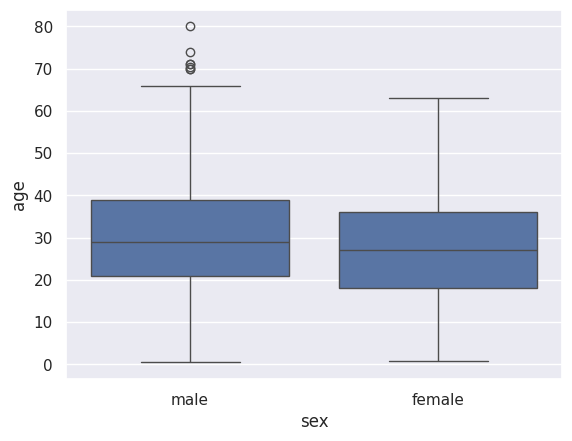

In [50]:
plt.figure()
# create a seaborn box plot with sex vs age
#mean = titanic[titanic["age"]].skipna().mean()
sns.boxplot(data=titanic, x="sex", y="age")

Let's proceed with taking a visual look at survival rates. Intuitively a good feature for survival rate would be the gender and class of a passenger.

We can display both in a histogram.

In [60]:
titanic[["class", "survived"]]

,class,survived
0,Third,0
1,First,1
2,Third,1
3,First,1
4,Third,0
...,...,...
886,Second,0
887,First,1
888,Third,0
889,First,1


<Axes: xlabel='survived', ylabel='class'>

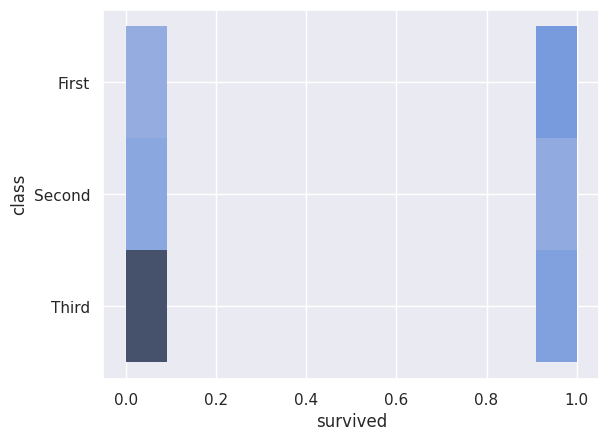

In [74]:
# create a histgram with seaborn for the survived category for each class
sns.histplot(data=titanic, x="survived", y="class")

<Axes: xlabel='survived', ylabel='who'>

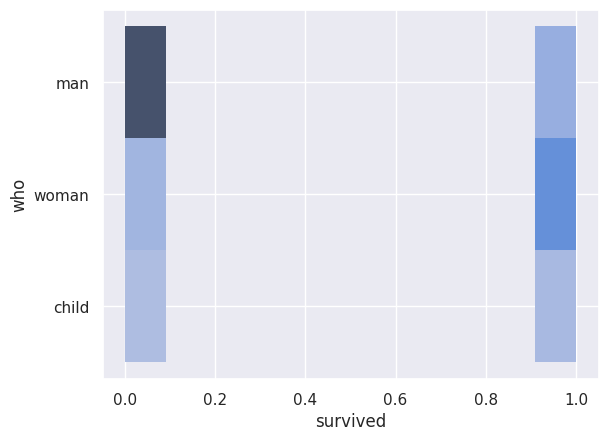

In [76]:
# create a histgram with seaborn for the survived category and the "who" category
sns.histplot(data=titanic, x="survived", y="who", multiple="dodge", shrink=.8)

We could already build our first hand-engineered simple classifier. From the figures we can observe that survival is very much related to being a female first class passenger.  To provide a better overview we will do this later and compare it with our logistic regression results.

We are now ready to build our dataset with our selected features and write the code for the logistic regression itself. As a first subset we will select the features *sex, fare, parch, pclass and sibsp (number of siblings or spouses)*. For this we will do a final conversion of the *sex* column and drop one entry as each passenger has an entry for both female and male that are mutually exclusive (0, 1 or 1, 0). We can thus just drop one of the entries entirely.

It's easiest if we concatenate (with *pd.concat*) the selected features into a new pandas data frame and then convert them to numpy matrices. The latter can be achieved by using the *pd.DataFrame.to_numpy(data_frame)* function.

In order to have a format that is suitable for logistic regression we will also split the labels, in the titanic scenario the *survived* column, into a separate numpy array.

In [93]:
sex = pd.get_dummies(titanic["sex"], drop_first=True)

# subselect the categories sex, fare, parch, pclass, sibsp and concatenate them
# into a new pandas dataframe called features

features = titanic[["sex", "fare", "parch", "pclass", "sibsp"]]
print(features)

x = np.array(features, dtype=float) # convert features to numpy array/matrix
y = np.array(titanic["survived"], dtype=float) # convert the survived category into numpy array

        sex     fare  parch  pclass  sibsp
0      male   7.2500      0       3      1
1    female  71.2833      0       1      1
2    female   7.9250      0       3      0
3    female  53.1000      0       1      1
4      male   8.0500      0       3      0
..      ...      ...    ...     ...    ...
886    male  13.0000      0       2      0
887  female  30.0000      0       1      0
888  female  23.4500      2       3      1
889    male  30.0000      0       1      0
890    male   7.7500      0       3      0

[889 rows x 5 columns]


ValueError: could not convert string to float: 'male'

## Creation of training and test data splits
The numpy matrices we have just created still lack multiple steps before we can treat them as datasets for logistic regression.
    1. The passanger entries are sorted. This can be problematic if we use stochastic gradient descent methods as some features will be fed first.
    2. We do not have a train and test split. Creation of this split is crucial as it gives us means to estimate whether our trained model can extrapolate to "unseen" data from the same data distribution, how much it generalizes and how much the model overfits, i.e. "learns by heart".
    
Let's create a held-out test set by first shuffling the dataset and then extracting 20% of the data.

We will also have to reshape the labels from vectors to matrices because of shape expectations of numpy's internal matrix multiplication.

In [85]:
# create random permutation of indices of length of the dataset.
# You can use np.random.permutation for this
perm = np.random.permutation(len(x))

split = 0.8
# subselect 80% of the generated permuted indices to split the training data
x_train = x[perm[:int(split*len(x))]] # first 80% of perm
y_train = y[perm[:int(split*len(y))]]

# use the remaining 20% to get a test split
x_test = x[perm[int((split)*len(x)):]] # remaining 20% of perm
y_test = y[perm[int((split)*len(y)):]]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# reshape the labels to fit later matrix multiplications (add a dummy dimension)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(y_train.shape, y_test.shape)

(711, 5) (178, 5) (711,) (178,)
(711, 1) (178, 1)


## Logistic regression

We are ready for the final step. We will now need to implement the missing functionality for the logistic regression itself:
    1. The sigmoid function  
    2. The cross-entropy loss function
    3. The gradient update rule
    4. The training loop
    5. A function to test accuracy on the dataset splits

Sigmoid function: $\frac{1}{1 + e^{-z}}$

In [119]:
def sigmoid(z):
    """
    Compute the Sigmoid function

    Parameters:
        z (float, np.array): scalar value or numpy array

    Returns:
        float, np.array: sigmoid(x)
    """
    #z = np.clip(z, -500, 500)
    sig = 1 / (1 + np.exp(-z))

    return sig

Cross-entropy loss: $−(y \log(p)+(1−y)\log(1−p))$

In [156]:
def log_loss(y, y_hat):
    """
    Cross-entropy loss function

    Parameters:
        y (float, np.array): Labels or targets
        y_hat (float, np.array): Predictions

    Returns:
    float: log loss
    """
    if y.shape != y_hat.shape:
        raise ValueError(f"Incompatible shapes: {y.shape} vs {y_hat.shape}")

    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)

    loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss

Gradient update, for now let's implement the regular easiest gradient descent update:

In [88]:
def grad_update(grad, lr):
    """
    Gradient descent update rule

    Parameters:
        grad (float, np.array): Array of gradients for each weight
        lr (float): learning rate
    """
    return lr * grad

We initialize the weights and bias to zero and set a number of epochs to train and a learning rate to use in the update. Good starting values can be 10000 epochs with a learning rate of 0.005.

In [138]:
for row in x_train:
    if row[0] == 'male':
        row[0] = 0
    elif row[0] == 'female':
        row[0] = 1


In [141]:
for row in y_train:
    if row[0] == 'male':
        row[0] = 0
    elif row[0] == 'female':
        row[0] = 1

In [149]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("W shape:", W.shape)

x_train shape: (711, 5)
y_train shape: (711, 1)
W shape: (5, 1)


In [158]:
W = np.zeros((x_train.shape[1], 1)) # initialize the weights with zeros. The shape should be feature_size, 1
b = 0.0 # initialize the biases with zeros. It is enough to use one bias value.

num_epochs = 10000
lr = 0.005

losses = []

for epoch in range(num_epochs):
    # Use x_train instead of x for calculating z
    z = np.dot(x_train, W) + b # do the linear weighting
    z = z.astype(float)
    A = sigmoid(z)# apply sigmoid function to get the prediction score
    loss = log_loss(y_train, A) # use your previously defined loss function to calculate the loss
    losses.append(loss)

    # compute the gradients of the cost function with respect to the weights
    dz = A - y_train
    dW = np.dot(x_train.T, dz) / x_train.shape[0] # Use x_train for dW calculation
    db = np.sum(dz) / x_train.shape[0] # Use x_train for db calculation

    W += grad_update(W, lr) # update the weights
    b -= grad_update(b, lr) # update the biases

    if epoch % 1000 == 0 and epoch > 0:
        print(loss)

Streaming output truncated to the last 5000 lines.
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy

We should have seen the loss decreasing over time. For the trained model we can now print the weights and bias values. Unfortunately because logistic regression weights aren't linearly, but multiplicatively combined, it is not straight forward to interpret these weights.

Don't worry though, in the next weeks we will learn about interpretability and how to inspect models!

In [159]:
print(W, b)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]] 0.0


Let's visualize our losses. Because we have so many values, it is recommended to take every tenth value only.

In [ ]:
# plot every tenth value of the loss

While looking at the losses can be meaningful, it doesn't really help our human interpretation of how well we can do on our task of predicting passenger survival. As our model is prediction survival score (like a probability in [0, 1] range.) we can binarize the prediction to yield *survived* if the output value is greater than 0.5. We can calculate this for the entire train and test dataset splits and see how well our model does in terms of accuracy.

In [170]:
def eval_acc(x, y):
    acc = 0.0

    # loop through the entire dataset and accumulate accuracy
    for inp in range(x.shape[0]):
        # this will be the same as your training code, but without gradients
        # or updates
        row = x[inp].astype(float)
        z = np.dot(x[inp], W)
        z = np.array(z, dtype=np.float64)
        A = sigmoid(z)

        # check if the prediction matches the label. Note that we consider a
        # label of 1 to match the prediction if the prediction is > 0.5 and vice
        # versa
        prediction = 1 if A > 0.5 else 0
        true_label = y[inp]

        if prediction == true_label:
            acc += 1.0

    # normalize the accumulated accuracy by the length of the dataset.
    acc /= x.shape[0]
    return acc

In [172]:
def eval_acc(x, y):
    acc = 0.0

    # loop through the entire dataset and accumulate accuracy
    for inp in range(x.shape[0]):
        # this will be the same as your training code, but without gradients
        # or updates
        # Convert the row to float to ensure numerical computation
        row = x[inp].astype(float)
        z = np.dot(row, W)
        z = np.array(z, dtype=np.float64)
        A = sigmoid(z)

        # check if the prediction matches the label. Note that we consider a
        # label of 1 to match the prediction if the prediction is > 0.5 and vice
        # versa
        prediction = 1 if A > 0.5 else 0
        true_label = y[inp]

        if prediction == true_label:
            acc += 1.0

    # normalize the accumulated accuracy by the length of the dataset.
    acc /= x.shape[0]
    return acc

In [174]:
# Convert 'male' and 'female' to 0 and 1 in x_test as well
for row in x_test:
    if row[0] == 'male':
        row[0] = 0
    elif row[0] == 'female':
        row[0] = 1

In [175]:
train_acc = eval_acc(x_train, y_train) # evaluate the train accuracy on the trained model
test_acc = eval_acc(x_test, y_test) # evaluate the test accuracy on the trained model

print("Training accuracy: ", train_acc)
print("Testing accuracy: ", test_acc)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

Depending on the exact random split and our gradient descent parameters we can observe training and testing accuracies greater than 80%. If the training accuracy is higher and the test accuracy is low this means that the model is overfitting. If neither of the two accuracies go beyond random chance of 50% (a coin-flip of whether a passenger survived or not) then the model has not trained or the gradient descent got stuck in a local minimum.

To an extend we can avoid gradient descent (GD) getting stuck in bad local minima or saddle points by making it stochastic (SGD). In the lecture we have encountered a method called mini-batch stochastic gradient descent, that balances the advantages of SGD stochasticity and convergence of GD.

Let's pick a starting batch size of 200 and see how the training behavior changes. Because we are now doing many more updates than before, it is generally a good idea to lower the learning rate a little or train for an overall lesser amount of epochs. We do not change the number of epochs here but instead halve the learning rate.

In [ ]:
W = # initialize the weights with zeros. The shape should be feature_size, 1
b = # initialize the biases with zeros. It is enough to use one bias value.

num_epochs = 10000
lr = 0.0025
mb_size = 200

losses = []

for epoch in range(num_epochs):

    # in stochastic gradient descent we shuffle the train dataset at the
    # beginning of every epoch to avoid
    perm = # create permuted integer indices for each dataset element
    x_train, y_train = # shuffle the training dataset

    # loop through the dataset in mini-batches
    # because we are shuffling the dataset at every point and we do not want
    # updates on a tiny batch size we can neglect the last mini-batch that is
    # smaller than our mini-batch nice.
    for mb in range(...):
        inp = x_train[..:..] # subselect the current mini-batch train examples
        target = y_train[..:..] # subselect the current mini-batch of labels

        # as before calculate the model, gradients and do the update.

    if epoch % 1000 == 0 and epoch > 0:
        print(loss)

Let's again visualize the losses

In [ ]:
# visalize the losses again

In contrast to gradient descent, we observe that the loss no longer behaves deterministically. It is a lot more "jumpy". In fact, if we run the same code multiple times we will also achieve a different result each time. Similarly, the final accuracy we achieve now varies. If we set the parameters right, we can observe the loss initially declining much faster and the final accuracy can be slightly higher.

In [ ]:
train_acc = ...
test_acc = ...

print("Training accuracy: ", train_acc)
print("Testing accuracy: ", test_acc)

## What now?

What can we do now? In the next week we will learn about more expressive models like random forests and neural networks that achieve better accuracies and can fit more complex tasks with more than one label.
For now here's a couple of suggestions what we can do immediately:


    1. Run gradient descent multiple times in a row, do the same for stochastic gradient descent, what do you observe and why?
    2. How does the model behave if we select a different smaller/large feature set?
    3. We have learned about more advanced gradient descent techniques such as momentum or adaptive techniques such as Adam. Change the update function and observe what happens.
    4. We have observed earlier that the sex and class feature seem to be highly correlated with survival rate. Can you build a simple classifier by hand, based on the assumption that high passenger class female passengers survive. How does it compare to the logistic regression you have trained?